In [1]:
# !uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !uv pip install kaggle
# !uv pip install matplotlib
!uv pip install pystac-client planetary-computer

Resolved 24 packages in 842ms                                        
⠙ Preparing packages... (0/7)                                                   
⠙ Preparing packages... (0/7)--------------     0 B/20.73 KiB           
⠙ Preparing packages... (0/7)---------- 14.88 KiB/20.73 KiB         
⠙ Preparing packages... (0/7)---------- 14.88 KiB/20.73 KiB         
python-dotenv        ------------------------------ 14.88 KiB/20.73 KiB
⠙ Preparing packages... (0/7)--------------     0 B/386.06 KiB          
python-dotenv        ------------------------------ 14.88 KiB/20.73 KiB
⠙ Preparing packages... (0/7)--------------     0 B/386.06 KiB          
python-dotenv        ------------------------------ 14.88 KiB/20.73 KiB
⠙ Preparing packages... (0/7)--------------     0 B/386.06 KiB          
python-dotenv        ------------------------------ 14.88 KiB/20.73 KiB
rpds-py              ------------------------------     0 B/386.06 KiB
⠙ Preparing packages... (0/7)--------------     0 B/452.54 K

In [2]:
# !kaggle datasets download \
#   -d honeybadger128bit/multispectral-field-images \
#   -p ./data/multispectral-field-images \
#   --unzip


# Sources:
https://github.com/satellite-image-deep-learning/datasets

https://github.com/Agri-Hub/Callisto-Dataset-Collection?tab=readme-ov-file

https://zenodo.org/records/6866847

# Init

In [5]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import geopandas as gpd
import torch
from torch.utils.data import Dataset
import logging
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

logging.basicConfig(
    level=logging.WARN,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

# honeybadger128bit/multespectral-field-images for scaled testing
https://www.kaggle.com/datasets/honeybadger128bit/multespectral-field-images

In [ ]:
def download_kaggle_dataset(dataset_slug: str, target_dir: str, unzip: bool = True):
    """
    Downloads a Kaggle dataset and (optionally) unzips it.

    :param dataset_slug: The Kaggle dataset identifier, e.g. "honeybadger128bit/multespectral-field-images"
    :param target_dir: Where to download / extract the dataset
    :param unzip: Whether to unzip the downloaded zip file(s)
    """
    api = KaggleApi()
    api.authenticate()

    os.makedirs(target_dir, exist_ok=True)

    logging.info(f"Downloading dataset {dataset_slug} to {target_dir} …")
    api.dataset_download_files(dataset_slug, path=target_dir, unzip=False)

    # Find downloaded zip(s) and optionally unzip
    for fname in os.listdir(target_dir):
        if fname.endswith(".zip"):
            full_path = os.path.join(target_dir, fname)
            logging.info(f"Found zip: {full_path}")
            if unzip:
                logging.info(f"Unzipping {full_path} …")
                with zipfile.ZipFile(full_path, 'r') as z:
                    z.extractall(target_dir)
                logging.info(f"Removing zip file {full_path}")
                os.remove(full_path)

if __name__ == "__main__":
    # Example usage
    dataset = "honeybadger128bit/multespectral-field-images"
    target_directory = "data/multispectral_images"

    # download_kaggle_dataset(dataset, target_directory, unzip=True)


Item shape: (152, 198, 14)


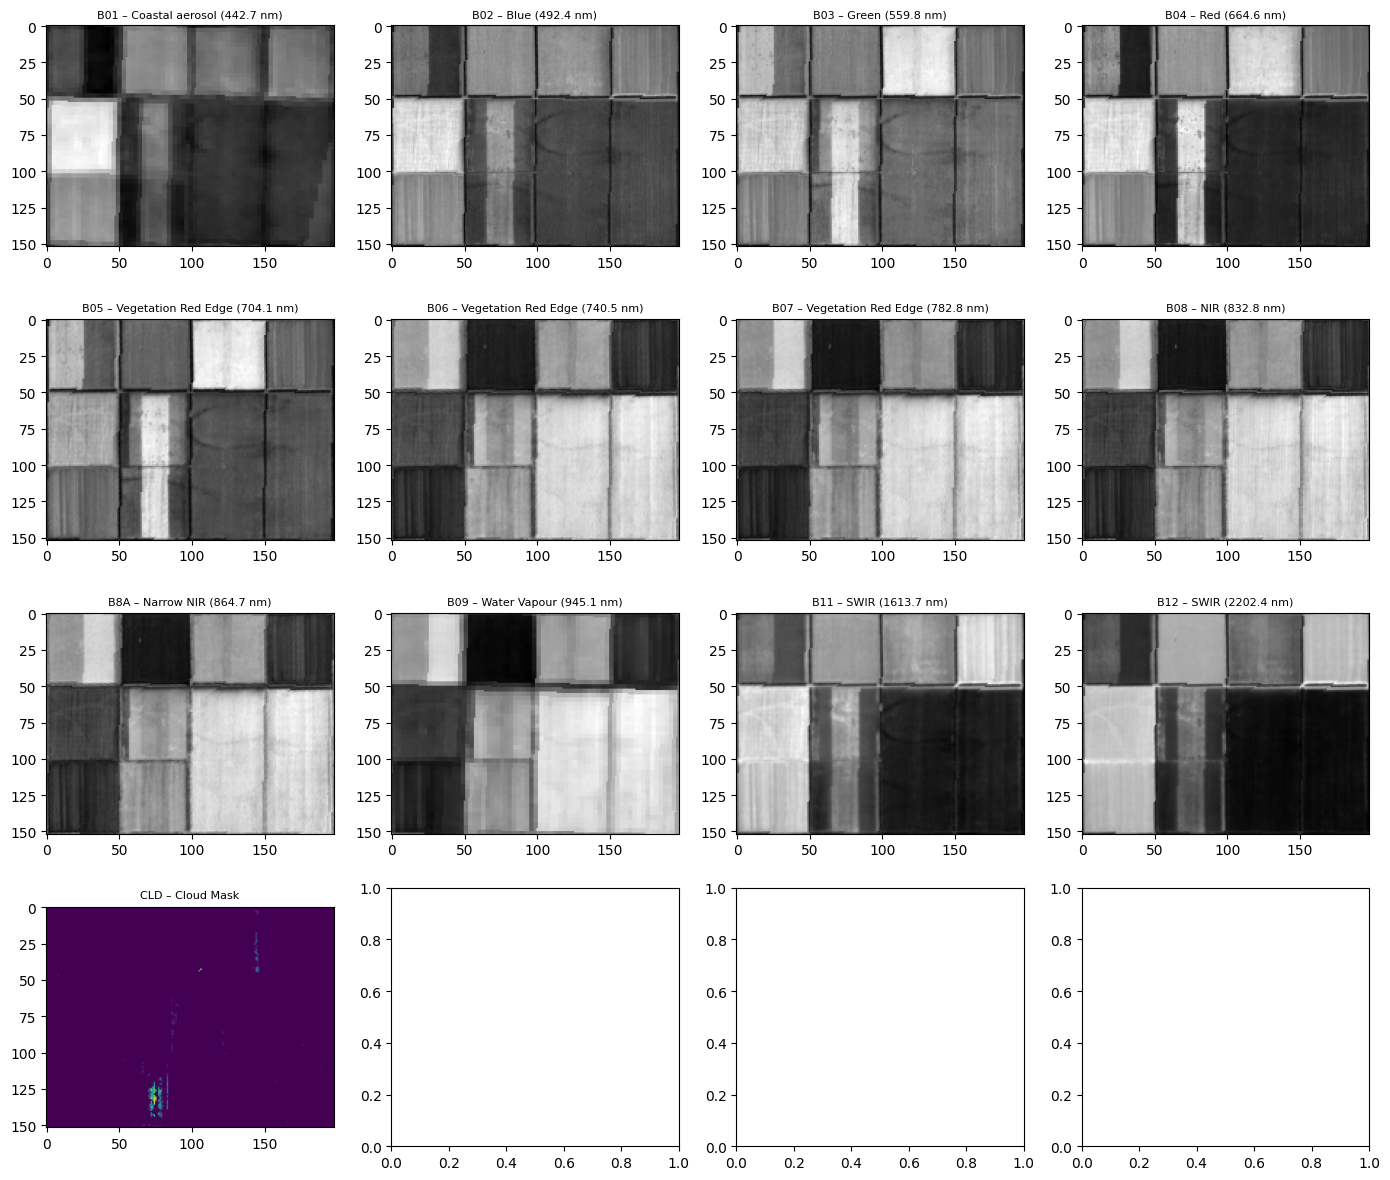

In [6]:
from typing import Any


class MultispectralImagesofFieldsDataset(Dataset):
    def __init__(self):
        self.annotations: pd.DataFrame = None
        self.load_annotations()
        # self.images: list = []
        # self.load_all_images()

    def load_annotations(self):
        logging.info("Loading annotations...")
        table1 = pd.read_csv('./data/multispectral_images/table_field1.csv')
        table2 = pd.read_csv('./data/multispectral_images/table_field2.csv')
        df = pd.concat([table1, table2], ignore_index=True)
        logging.info(f"Loaded annotaions:\n\r{df.head(1)}")
        self.annotations = df

    def load_all_images(self):
        logging.info("Loading images...")
        for _, row in self.annotations.iterrows():
            json_path = row["path"]

            json_path = json_path.replace("files/", "data/multispectral_images/")
            json_path = json_path + ".json"
            with open(json_path, "r") as f:
                data = json.load(f)

            matrix_3d = np.array(data["data"])
            self.images.append(matrix_3d)

            logging.info(f"Loaded image: {json_path}")

    def __getitem__(self, index) -> Any:
        logging.info("Loading item...")

        row = self.annotations.iloc[index]

        json_path = row["path"]
        json_path = json_path.replace("files/", "data/multispectral_images/")
        json_path = json_path + ".json"

        # Load JSON file
        with open(json_path, "r") as f:
            data = json.load(f)

        matrix_3d = np.array(data["data"])

        logging.info(f"Loaded image: {json_path}")

        return matrix_3d
    
    def visualize_datapoint(self, index):

        channel_titles = [
            "B01 – Coastal aerosol (442.7 nm)",
            "B02 – Blue (492.4 nm)",
            "B03 – Green (559.8 nm)",
            "B04 – Red (664.6 nm)",
            "B05 – Vegetation Red Edge (704.1 nm)",
            "B06 – Vegetation Red Edge (740.5 nm)",
            "B07 – Vegetation Red Edge (782.8 nm)",
            "B08 – NIR (832.8 nm)",
            "B8A – Narrow NIR (864.7 nm)",
            "B09 – Water Vapour (945.1 nm)",
            "B11 – SWIR (1613.7 nm)",
            "B12 – SWIR (2202.4 nm)",
            "CLD – Cloud Mask"
        ]

        item = self.__getitem__(index)  # shape: (H, W, C)
        print("Item shape:", item.shape)

        H, W, C = item.shape
        C -= 1
        assert C == 13, f"Expected 13 channels, got {C}"

        # Grid: 4 columns, enough rows to fit 14 channels
        cols = 4
        rows = (C + cols - 1) // cols  # ceil division

        fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
        axes = axes.flatten()

        for i in range(cols * rows):
            ax = axes[i]
            if i < C:

                # Cloud mask should be shown differently
                if channel_titles[i].startswith("CLD"):
                    ax.imshow(item[:, :, i], cmap="viridis")
                else:
                    ax.imshow(item[:, :, i], cmap="gray")

                ax.set_title(channel_titles[i], fontsize=8)

        plt.tight_layout()
        plt.show()

multispectralImagesofFieldsDataset = MultispectralImagesofFieldsDataset()
multispectralImagesofFieldsDataset.visualize_datapoint(32)

# Full Dataset
https://registry.opendata.aws/sentinel-2-l2a-cogs/

In [ ]:
from pystac_client import Client
stac_url = "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
catalog = Client.open(stac_url)
print(catalog)

collections = catalog.get_collections()
for c in collections:
    print(c.id, "-", c.title)

<Client id=microsoft-pc>
daymet-annual-pr - Daymet Annual Puerto Rico
daymet-daily-hi - Daymet Daily Hawaii
3dep-seamless - USGS 3DEP Seamless DEMs
3dep-lidar-dsm - USGS 3DEP Lidar Digital Surface Model
fia - Forest Inventory and Analysis
gridmet - gridMET
daymet-annual-na - Daymet Annual North America
daymet-monthly-na - Daymet Monthly North America
daymet-annual-hi - Daymet Annual Hawaii
daymet-monthly-hi - Daymet Monthly Hawaii
daymet-monthly-pr - Daymet Monthly Puerto Rico
gnatsgo-tables - gNATSGO Soil Database - Tables
hgb - HGB: Harmonized Global Biomass for 2010
cop-dem-glo-30 - Copernicus DEM GLO-30
cop-dem-glo-90 - Copernicus DEM GLO-90
terraclimate - TerraClimate
nasa-nex-gddp-cmip6 - Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6)
gpm-imerg-hhr - GPM IMERG
gnatsgo-rasters - gNATSGO Soil Database - Rasters
3dep-lidar-hag - USGS 3DEP Lidar Height above Ground
io-lulc-annual-v02 - 10m Annual Land Use Land Cover (9-class) V2
goes-cmi - GOES-R Cloud & Moisture

/home/jrosa/AGH_FILES/GSN-2025W-PuchaczPansharpening/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
